First import required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import digamma 
from scipy.linalg import sqrtm
import seaborn as sns

# Regression Spline
Assume that the range of x is $[a,b]$. Let the point
$$ a < \xi_1 < \dots < \xi_K < b$$
be a partion of the interval $[a,b]$  
$\left\{ \xi_1 , \dots , \xi_K \right\}$ are called knots.

Then make the function which return the knot points

In [2]:
def defineKnot(X,K=30):
    upper = max(X)
    lower = min(X)
    out = np.linspace(start=lower,stop=upper,num=K+2)[1:K+1]
    return(out)

# Radial Basis Function
A RBF $\varphi$ is a real valued function whose value depends only on the distance from origin.
A real function $\varphi : [0,\infty) \rightarrow {\rm I\!R}$ with a metric on space $\| \cdot \| : V \rightarrow [0,\infty)$ a function $\varphi_c = \varphi(\|\mathbf{x} - \mathbf{c}\|)$ is said to be a radial kernel centered at c. A radial function and the associated radial kernels are said to be radial basis function

we use radial basis functions defined by
$$
\mathbf{b}(u) = \left\{  u, \left| \frac{u-\tau_1}{c} \right|^3 , \cdots , \left| \frac{u-\tau_K}{c} \right|^3 \right\}
$$
where $c$ is sample standard deviation 

Then we can make the function which retrun the basis

In [3]:
def b(u,tau,sd):
    lst = []
    #lst.append(np.ones(len(u)))
    #lst.append(u)
    for i in tau:
        lst.append(abs((u-i)/sd)**3)
    out = np.array(lst)
    return(out)

Nonparametric linear model can be represented as
$$ Y = \mathbf{b}(X) \boldsymbol{\beta} + \varepsilon$$
where $Y \in  {\rm I\!R}^{n\times1}, X \in  {\rm I\!R}^{n\times1}$ and $\varepsilon \sim N(0,\tau^{-1})$

# Make toy data

Let
$$y = \sum_{l=1}^{4} f_l(X_l) + \sum_{k=1}^{4} Z_k \theta_k + e $$

$$
\begin{align*}
f_1(x) &= 3exp(-30(x-0.3)^2)+exp(-50(x-0.7)^2)\\
f_2(x) &= sin(2\pi x)\\
f_3(x) &= x\\
f_4(x) &= 0
\theta_1 &= 0.6\\
\theta_2 &= -1\\
\theta_3 &= 0\\
\theta_4 &= 0
\end{align*}
$$

Plotting true distribution of $Y$ is

In [4]:
def f(x):
    #out = np.sin(2*np.pi*x)
    out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    return(out)

In [5]:
def f1(x):
    #out = np.sin(2*np.pi*x)
    out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    return(out)
def f2(x):
    out = np.sin(2*np.pi*x)
    #out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    return(out)
def f3(x):
    #out = np.sin(2*np.pi*x)
    #out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    out = x
    return(out)
def f4(x):
    #out = np.sin(2*np.pi*x)
    #out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    out = 0*x
    return(out)

In [6]:
def product(a):
    n = len(a)
    out = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            out[i,j] = a[i]*a[j]
    return(out)

In [7]:
grid_x = np.linspace(0,1,1000)
grid_y = f(grid_x)

In [8]:
#plt.plot(grid_x, grid_y, 'k')
#plt.ylim(lim)
#plt.show()

make the simulation function which make the obs with error $N(0,0.5)$

In [9]:
def mkToy(n=800,tau = 0.5):
    np.random.seed(4428)
    x = np.random.uniform(size = n)
    e = np.random.normal(0,np.sqrt(0.5), size= n)
    y = f(x) + e
    #out = np.column_stack([x,y])
    return(x,y)

In [10]:
def mkToys(n=800,tau = 0.5):
    np.random.seed(4428)
    #non linear
    x1 = np.random.uniform(size = n)
    x2 = np.random.uniform(size = n)
    x3 = np.random.uniform(size = n)
    x4 = np.random.uniform(size = n)
    #linear
    z1 = np.random.uniform(size = n)
    z2 = np.random.uniform(size = n)
    z3 = np.random.uniform(size = n)
    z4 = np.random.uniform(size = n)
    e = np.random.normal(0,np.sqrt(0.5), size= n)
    y = f1(x1) + f2(x2) + f3(x3) + f4(x4)+ 0.6*z1 -1*z2 + e
    #out = np.column_stack([x,y])
    return(x1,x2,x3,x4,z1,z2,z3,z4,y)

Plotting the distribution of simulated data
$$y = f_1(X_1) +f_2(X_2) +f_3(X_3) +f_4(X_4)   + \varepsilon$$
where $\varepsilon \sim N(0,0.5)$

In [11]:
#x, y = mkToys()
#y= y-y.mean()

$$\tilde{y} = y -\bar{y} = b_1(X_1)\beta_1 + b_2(X_2)\beta_2 + b_3(X_3)\beta_3 + b_4(X_4)\beta_4 + \varepsilon$$

In [12]:
df = pd.read_csv('betaplasma.csv').iloc[:,1:]

In [13]:
df.head()

,id,age,sex,smokestat,bmi,vituse,calories,fat,fiber,alcohol,chol,betadiet,retdiet,betacaro,retplasma
0,1,64,M,Former,21.48380,Often,1298.8,57.0,6.3,0.0,170.3,1945,890,200,915
1,2,76,M,Never,23.87631,Often,1032.5,50.1,15.8,0.0,75.8,2653,451,124,727
2,3,38,M,Former,20.01080,Not often,2372.3,83.6,19.1,14.1,257.9,6321,660,328,721
3,4,40,M,Former,25.14062,No,2449.5,97.5,26.5,0.5,332.6,1061,864,153,615
4,5,72,M,Never,20.98504,Often,1952.1,82.6,16.2,0.0,170.8,2863,1209,92,799


In [14]:
colName =[None,'age','bmi','calories','fat','fiber','alcohol','chol','betadiet','retdiet']
linearName = [None,'sex','smokestat','vituse']

In [15]:
y = df.betacaro.map(lambda x : np.log(x) if x!=0 else 0)

x1 = df.age
x2 = df.bmi
x3 = df.calories
x4 = df.fat
x5 = df.fiber
x6 = df.alcohol
x7 = df.chol
x8 = df.betadiet
x9 = df.retdiet

z1 = (df.sex=='M').map(lambda x : int(x))
z2 = (df.smokestat=='Never').map(lambda x : int(x)) + \
     (df.smokestat=='Former').map(lambda x : 2*int(x)) + \
     (df.smokestat=='Current').map(lambda x : 3*int(x)) 
z3 = (df.vituse=='Often').map(lambda x : int(x)) + \
     (df.vituse=='Not often').map(lambda x : 2*int(x)) + \
     (df.vituse=='No').map(lambda x : 3*int(x)) 

y = y-y.mean()
Z = np.array([z1,z2,z3]).T

Calculate the standard deviation of observed data and define the knot and make design matrix

In [16]:
sd1 = np.std(x1)
knot1 = defineKnot(x1)
d_x1 = b(x1,knot1,sd1).T

sd2 = np.std(x2)
knot2 = defineKnot(x2)
d_x2 = b(x2,knot2,sd2).T

sd3 = np.std(x3)
knot3 = defineKnot(x3)
d_x3 = b(x3,knot3,sd3).T

sd4 = np.std(x4)
knot4 = defineKnot(x4)
d_x4 = b(x4,knot4,sd4).T


d_x5 = b(x5,defineKnot(x5),np.std(x5)).T
d_x6 = b(x6,defineKnot(x6),np.std(x6)).T
d_x7 = b(x7,defineKnot(x7),np.std(x7)).T
d_x8 = b(x8,defineKnot(x8),np.std(x8)).T
d_x9 = b(x9,defineKnot(x9),np.std(x9)).T

# LSE method
plotting the fitted value

In [17]:
def rdplot(x,d_x):
    #try:
    fitted = d_x.dot(np.linalg.inv(d_x.T.dot(d_x))).dot(d_x.T).dot(y)
    #except:
    #    fitted = d_x.dot(product(d_x)).dot(d_x.T).dot(y)
    plot_m = np.array(sorted(np.array([x,fitted]).T,key=lambda x: x[0]))
    plt.plot(plot_m[:,0],plot_m[:,1],'k')    

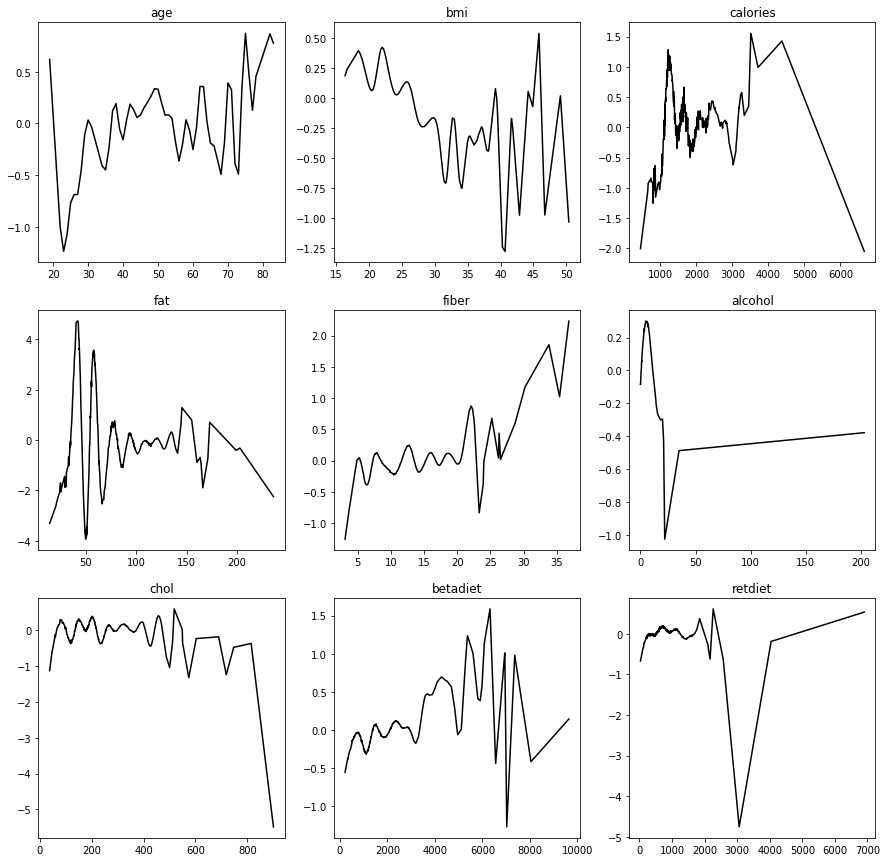

In [18]:
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title(colName[1])
rdplot(x1,d_x1)

plt.subplot(332)
plt.title(colName[2])
rdplot(x2,d_x2)

plt.subplot(333)
plt.title(colName[3])
rdplot(x3,d_x3)


#plt.figure(figsize=(15,2.5))

plt.subplot(334)
plt.title(colName[4])
rdplot(x4,d_x4)

plt.subplot(335)
plt.title(colName[5])
rdplot(x5,d_x5)

plt.subplot(336)
plt.title(colName[6])
rdplot(x6,d_x6)



#plt.figure(figsize=(15,2.5))

plt.subplot(337)
plt.title(colName[7])
rdplot(x7,d_x7)

plt.subplot(338)
plt.title(colName[8])
rdplot(x8,d_x8)

plt.subplot(339)
plt.title(colName[9])
rdplot(x9,d_x9)



Blue dashed line is true function and solid line is LSE estimated function

# MFVB method
setting prior as
$$
\begin{align*}
 p(Y|\tau,\beta)  &\sim N(X\beta , \tau^{-1} \cdot I_N)\\
 p(\beta_i | \gamma_i) &\sim^{ind} N(0,\gamma^{-1}) \text{ for } i=1,\dots p \\
 p(\gamma) &\sim Gamma(a,b) \\
 p(\tau) &\sim Gamma(c,d)   
\end{align*}
$$

By Baye's rule
$$
p(\tau,\gamma ,\beta | Y) \propto p(Y|\tau,\beta) p(\beta | \gamma) p(\tau) p(\gamma) 
$$
Then variational distribution is
$$
p(\tau,\gamma ,\mu | Y) \approx q(\tau,\gamma,\mu) = q_1(\tau) q_2(\gamma) q_3(\mu)
$$
we can maximize ELBO by coordinate descent algorithm
$$
\begin{align*}
q_1^*(\tau) &= E_{q_2,q_3}[p(\tau,\gamma ,\beta | Y)] \propto E_{q_2,q_3}[p(Y|\tau,\beta)  p(\tau)]\\
q_2^*(\gamma) &= E_{q_1,q_3}[p(\tau,\gamma ,\beta | Y)] \propto E_{q_1,q_3}[ p(\beta | \gamma)   p(\gamma)]\\
q_3^*(\beta) &= E_{q_1,q_2}[p(\tau,\gamma ,\beta | Y)] \propto E_{q_1,q_2}[p(Y|\tau,\beta) p(\beta | \gamma)   ]\\
\end{align*}
$$
Then
$$
\begin{align*}
q_1^* &\sim Gamma\left(c + \frac{N+1}{2}, d + \frac{1}{2}\left\{Y'Y -E_{q3}[\beta'](X'Y)\right\} + tr\left[X(var_{q3}[\beta]+E_{q3}[\beta]E_{q3}[\beta'])X'\right]\right)\\
q_2^* &\sim \prod_{i=1}^{p}Gamma( a+ \frac{1}{2}, b + \frac{1}{2}\{var_{q3}[\beta]_{i,i} +E_{q3}[\beta_i]^2 \})\\
q_3^* &\sim N\left(E_{q1}[\tau]\Sigma X'Y,\left(diag(E_{q2}[\gamma]) + E_{q1}[\tau]X'X \right)^{-1} = \Sigma \right)
\end{align*}
$$

In [19]:
def mfvb(X,y,max_iter=100):
    
    N,p = X.shape
    a ,b, c, d = [10**(-7)]*4
    a_tilde = np.repeat(a + 0.5, p)
    b_tilde = np.repeat(b,p)
    c_tilde = c + (N+1)/2
    d_tilde = d
    
    mu_coeffs = np.repeat(0,p)
    sigma_coeffs = np.diag(np.repeat(1,p))
    
    for i in range(max_iter):
        expected_coeffs = mu_coeffs
        double_expected_coeffs = sigma_coeffs + product(mu_coeffs)
        diagonal_sigma = np.diag(sigma_coeffs)
        expected_alpha = np.array(list(map(lambda x : a_tilde[x]/b_tilde[x] , np.arange(0,p))))
        log_expected_alpha = np.array(list(map(lambda x : digamma(a_tilde[x])-np.log(b_tilde[x]) , np.arange(0,p))))
        expected_tau = c_tilde / d_tilde
        log_expected_tau = digamma(c_tilde)-np.log(d_tilde)
        sigma_coeffs = np.linalg.inv(np.diag(expected_alpha)+expected_tau*(X.T.dot(X)))
        mu_coeffs =  expected_tau*sigma_coeffs.dot(X.T.dot(y))
        b_tilde = np.array(list(map(lambda x : (diagonal_sigma[x]+mu_coeffs[x]**2)/2 + b , np.arange(0,p))))
        d_tilde = d+0.5*(y.T.dot(y)) - expected_coeffs.T.dot((X.T.dot(y)))+ 0.5*sum(np.diag(X.dot(double_expected_coeffs).dot(X.T)))
    return mu_coeffs,sigma_coeffs

In [20]:
m1,c1 = mfvb(d_x1,y)
m2,c2 = mfvb(d_x2,y)
m3,c3 = mfvb(d_x3,y)
m4,c4 = mfvb(d_x4,y)
m5,c5 = mfvb(d_x5,y)
m6,c6 = mfvb(d_x6,y)
m7,c7 = mfvb(d_x7,y)
m8,c8 = mfvb(d_x8,y)
m9,c9 = mfvb(d_x9,y)

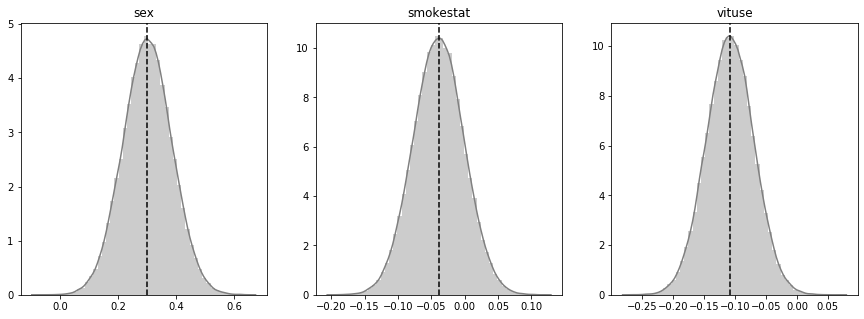

In [21]:
lm,lc = mfvb(Z,y)
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title(linearName[1])
sns.distplot(np.random.normal(lm[0],np.sqrt(lc[0,0]),100000),color = 'gray')
plt.axvline(lm[0], color = 'k',linestyle='--')

plt.subplot(132)
plt.title(linearName[2])
sns.distplot(np.random.normal(lm[1],np.sqrt(lc[1,1]),100000),color = 'gray')
plt.axvline(lm[1], color = 'k',linestyle='--')

plt.subplot(133)
plt.title(linearName[3])
sns.distplot(np.random.normal(lm[2],np.sqrt(lc[2,2]),100000),color = 'gray')
plt.axvline(lm[2], color = 'k',linestyle='--')

plt.show()

In [22]:
def ci95srd(m,c,x,d_x,n=10000):
    np.random.seed(4428)
    sampled_coef = np.random.multivariate_normal(m,c,size=n)
    y_grid = np.array([d_x.dot(b) for b in sampled_coef])
    quantile = np.array([np.sort(x)[[int(n*0.025),int(n*0.5),int(n*0.975)]] for x in y_grid.T])
    xq = np.array(sorted(np.array([x,quantile[:,0],quantile[:,1],quantile[:,2]]).T,key= lambda x : x[0]))
    plt.fill_between(xq[:,0], xq[:,1],xq[:,3], color =(0,0,0,0.2))
    plt.plot(xq[:,0],xq[:,2],'k')#,grid_x, y, '--')

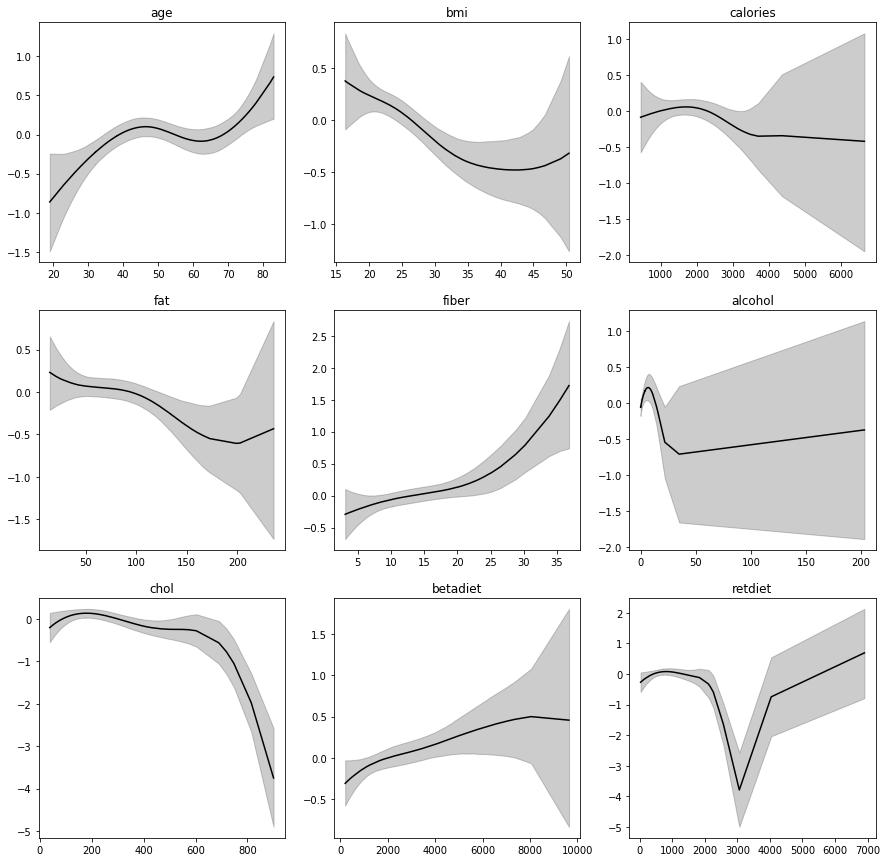

In [23]:
grid_x = np.linspace(0,1,1000)

plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title(colName[1])
ci95srd(m1,c1,x1,d_x1)

plt.subplot(332)
plt.title(colName[2])
ci95srd(m2,c2,x2,d_x2)

plt.subplot(333)
plt.title(colName[3])
ci95srd(m3,c3,x3,d_x3)

plt.subplot(334)
plt.title(colName[4])
ci95srd(m4,c4,x4,d_x4)

plt.subplot(335)
plt.title(colName[5])
ci95srd(m5,c5,x5,d_x5)

plt.subplot(336)
plt.title(colName[6])
ci95srd(m6,c6,x6,d_x6)

plt.subplot(337)
plt.title(colName[7])
ci95srd(m7,c7,x7,d_x7)

plt.subplot(338)
plt.title(colName[8])
ci95srd(m8,c8,x8,d_x8)

plt.subplot(339)
plt.title(colName[9])
ci95srd(m9,c9,x9,d_x9)

plt.show()

Dashed line is True function, solid line is median estimator and gray filled area is 95% confidence interval

# MFVB method with variable selection
Variable selection model is
$$
\begin{align*}
Y = X\Gamma\beta + \epsilon , \;\;\; \epsilon \sim N(0,\sigma^2 I)
\end{align*}
$$
where 
$$
\begin{align*}
Y|\beta,\sigma^2 ,\gamma &\sim N(X\Gamma\beta , \sigma^2 I)\\
\sigma^2 &\sim Inverse-Gamma(A,B)\\
\beta_j &\sim N(0, \sigma_{\beta}^2)\\
\gamma_j &\sim Bernoulli(\rho)
\end{align*}
$$

In [24]:
def expit(x):
    if x < 100:
        return(np.exp(x)/(1+np.exp(x)))
    else:
        return(1)

In [25]:
def vselect_wo_beta(X,y,maxiter=100,rho = 0.5):
    N,p = X.shape
    sigmab = 1
    A = 10**(-7)
    B = 10**(-7)
    tau = 1
    w = np.repeat(0.5,p)
    lamb= np.log(rho/(1-rho))
    t = 0
    for iteration in range(maxiter):
        test= False
        W = np.diag(w)
        omega = product(w) + W.dot(np.eye(p)-W)
        sigma = np.linalg.inv(tau*np.multiply(X.T.dot(X),omega)+ (1/sigmab) * np.eye(p))
        mu = tau*sigma.dot(W.dot(X.T.dot(y)))

        s = B + 0.5*(np.linalg.norm(y)**2 -2*y.T.dot(X).dot(W).dot(mu) + np.trace(np.multiply(X.T.dot(X),omega).dot(product(mu) +sigma)))
        tau = (A+N/2)/s

        wstar = w.copy()
        eta = np.zeros(p)
        for j in range(p):
            eta[j] = lamb - 0.5*tau *(mu[j]**2 + sigma[j,j])*np.linalg.norm(X[:,j])**2 + tau *X[:,j].T.dot(y*mu[j]-np.delete(X, j, axis=1).dot(np.diag(np.delete(wstar,j))).dot(np.delete(mu,j,0)*mu[j] + np.delete(sigma,j,axis=1)[j,:]))
            wstar[j] = expit(eta[j]) 
        w = wstar
        #print(np.array(eta).round(2))
        #print(np.array(wstar).round(2))
    return(mu,sigma,w)

In [30]:
def vselect_with_beta(X,y,maxiter=1000):#,rho = 0.46):
    #rho = 0.5
    beta_a , beta_b = 1,1.4
    beta_a_o , beta_b_o = 1,1.4
    N,p = X.shape
    sigmab = 1
    A = 10**(-7)
    B = 10**(-7)
    tau = 1
    w = np.repeat(0.5,p)
    #lamb= np.log(rho/(1-rho))
    t = 0
    for iteration in range(maxiter):
        lamb= digamma(beta_a) - digamma(beta_b)
        test= False
        W = np.diag(w)
        omega = product(w) + W.dot(np.eye(p)-W)
        sigma = np.linalg.inv(tau*np.multiply(X.T.dot(X),omega)+ (1/sigmab) * np.eye(p))
        mu = tau*sigma.dot(W.dot(X.T.dot(y)))

        s = B + 0.5*(np.linalg.norm(y)**2 -2*y.T.dot(X).dot(W).dot(mu) + np.trace(np.multiply(X.T.dot(X),omega).dot(product(mu) +sigma)))
        tau = (A+N/2)/s

        wstar = w.copy()
        eta = np.zeros(p)
        for j in range(p):
            eta[j] = lamb - 0.5*tau *(mu[j]**2 + sigma[j,j])*np.linalg.norm(X[:,j])**2 + tau *X[:,j].T.dot(y*mu[j]-np.delete(X, j, axis=1).dot(np.diag(np.delete(wstar,j))).dot(np.delete(mu,j,0)*mu[j] + np.delete(sigma,j,axis=1)[j,:]))
            wstar[j] = expit(eta[j]) 
        w = wstar
        beta_a = sum(w) + beta_a_o
        beta_b = p - sum(w) +beta_b_o
        #print(np.array(eta).round(2))
        #print(np.array(wstar).round(2))
    print(beta_a,beta_b)
    return(mu,sigma,w)

In [31]:
def cil95s(m,c,w,x,d_x,n=1000):
    np.random.seed(4428)
    sampled_coef = np.random.multivariate_normal(m,c,size=n)
    lst = []
    for j in w:
        lst.append(np.random.binomial(1,j))
    w2ar = np.array(lst)
    y_grid = np.array([d_x.dot(np.diag(w2ar)).dot(b) for b in sampled_coef])
    quantile = np.array([np.sort(x)[[int(n*0.05),int(n*0.5),int(n*0.95)]] for x in y_grid.T])
    xq = np.array(sorted(np.array([x,quantile[:,0],quantile[:,1],quantile[:,2]]).T,key= lambda x : x[0]))
    plt.fill_between(xq[:,0], xq[:,1],xq[:,3], color =(0,0,0,0.2))
    plt.plot(xq[:,0],xq[:,2],'k')

In [32]:
lms4,lcs4,lws4 = vselect_wo_beta(Z,y)

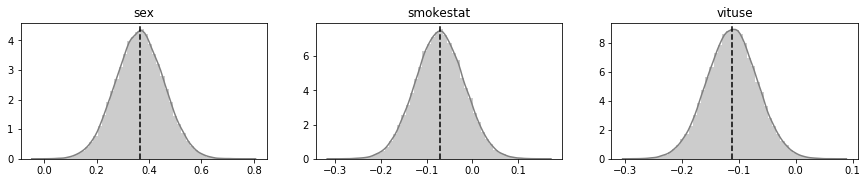

In [29]:
lms4,lcs4,lws4 = vselect_wo_beta(Z,y)
plt.figure(figsize=(15,2.5))

plt.subplot(131)
plt.title(linearName[1])
if lws4[0]!=0:
    sns.distplot(np.random.normal(lms4[0],np.sqrt(lcs4[0,0]),100000),color = 'gray')
    plt.axvline(lms4[0], color = 'k',linestyle='--')
else:
    sns.distplot(np.repeat(0,100000),color = 'gray')
    plt.axvline(-0, color = 'k',linestyle='--')

plt.subplot(132)
plt.title(linearName[2])
if lws4[1]!=0:
    sns.distplot(np.random.normal(lms4[1],np.sqrt(lcs4[1,1]),100000),color = 'gray')
    plt.axvline(lms4[1], color = 'k',linestyle='--')
else:
    sns.distplot(np.repeat(0,100000),color = 'gray')
    plt.axvline(-0, color = 'k',linestyle='--')
    
plt.subplot(133)
plt.title(linearName[3])
if lws4[2]!=0:
    sns.distplot(np.random.normal(lms4[2],np.sqrt(lcs4[2,2]),100000),color = 'gray')
    plt.axvline(lms4[2], color = 'k',linestyle='--')
else:
    sns.distplot(np.repeat(0,100000),color = 'gray')
    plt.axvline(-0, color = 'k',linestyle='--')
plt.show()

Spike and slab variable selection plot

$$y = \sum_{l=1}^{4} f_l(X_l) + e $$

$$
\begin{align*}
f_1(x) &= 3exp(-30(x-0.3)^2)+exp(-50(x-0.7)^2)\\
f_2(x) &= sin(2\pi x)\\
f_3(x) &= x\\
f_4(x) &= 0
\end{align*}
$$

파란색 점선은 각 함수의 참값을 나타내고 검은색 실선은 median estimator 회색 음영부분은 95%신뢰구간을 표현합니다  
위에서 부터 각각 LSE, Variational inference, Variational Inference with spike and slab prior 입니다  
변수 선택을 한 마지막 모형에서 함수가 0인 부분 을 잘 표현하는 것을 확인 할 수 있었습니다  

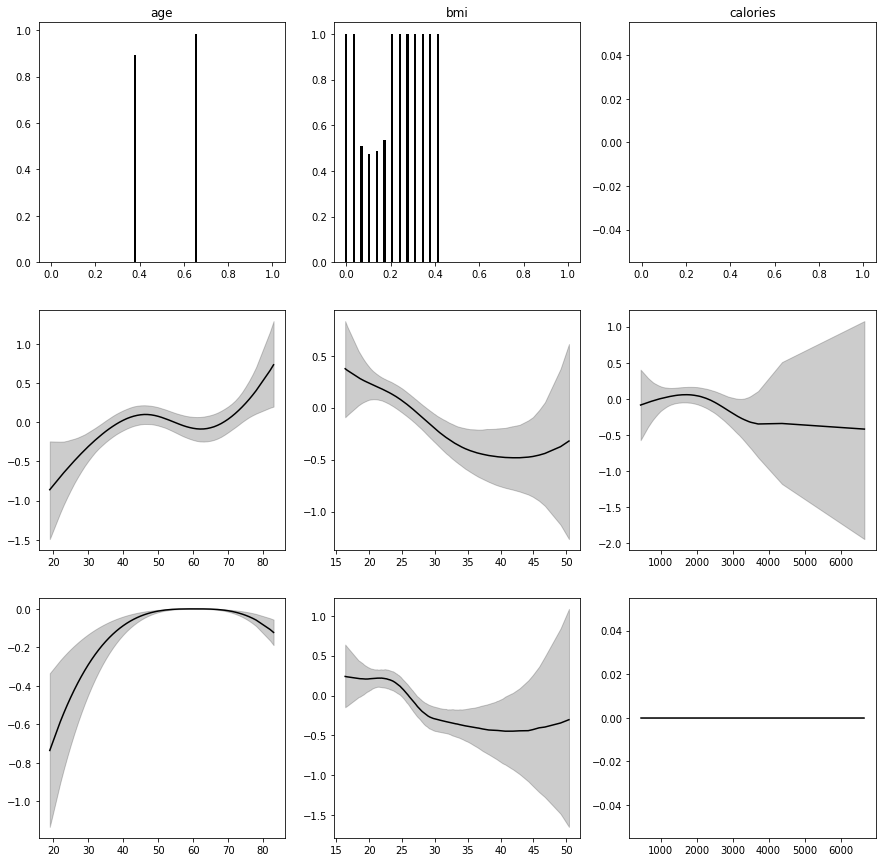

In [133]:
ms1,cs1,ws1 = vselect_wo_beta(d_x1,y)
ms2,cs2,ws2 = vselect_wo_beta(d_x2,y)
ms3,cs3,ws3 = vselect_wo_beta(d_x3,y)
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title(colName[1])
plt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

plt.subplot(332)
plt.title(colName[2])
plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

plt.subplot(333)
plt.title(colName[3])
plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')



plt.subplot(334)
#plt.title('f1')
ci95srd(m1,c1,x1,d_x1)

plt.subplot(335)
#plt.title('f2')
ci95srd(m2,c2,x2,d_x2)

plt.subplot(336)
#plt.title('f3')
ci95srd(m3,c3,x3,d_x3)



plt.subplot(337)
#plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1)

plt.subplot(338)
#plt.title('f2')
cil95s(ms2,cs2,ws2,x2,d_x2)

plt.subplot(339)
#plt.title('f3')
cil95s(ms3,cs3,ws3,x3,d_x3)


plt.show()

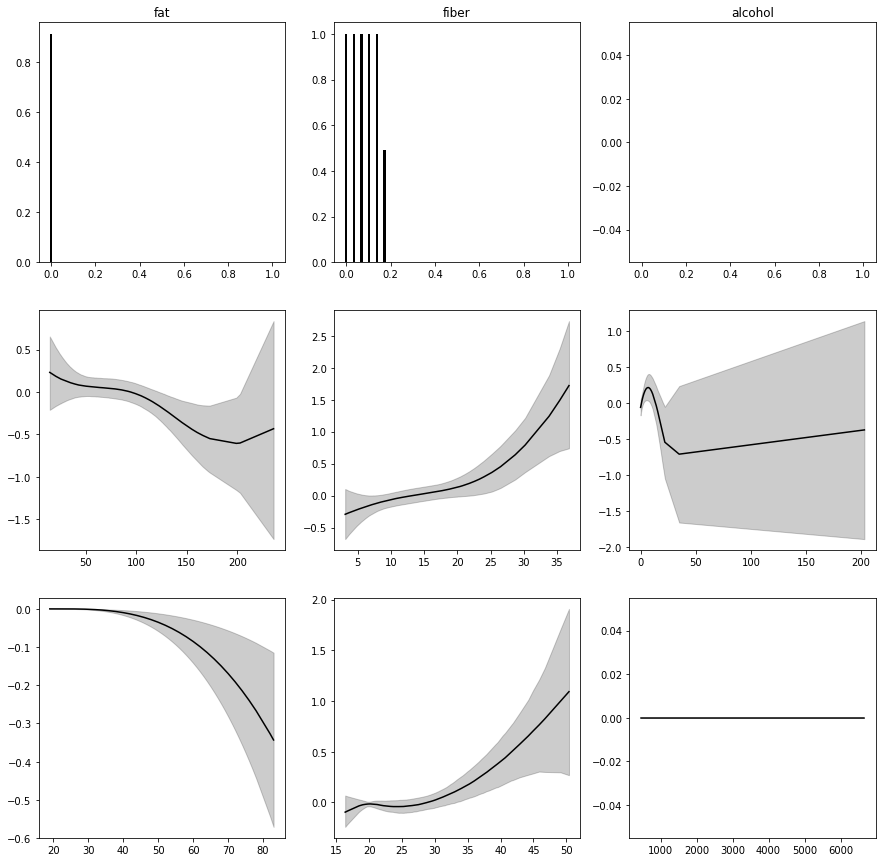

In [134]:
ms1,cs1,ws1 = vselect_wo_beta(d_x4,y)
ms2,cs2,ws2 = vselect_wo_beta(d_x5,y)
ms3,cs3,ws3 = vselect_wo_beta(d_x6,y)

plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title(colName[4])
plt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

plt.subplot(332)
plt.title(colName[5])
plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

plt.subplot(333)
plt.title(colName[6])
plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')



plt.subplot(334)
#plt.title('f1')
ci95srd(m4,c4,x4,d_x4)

plt.subplot(335)
#plt.title('f2')
ci95srd(m5,c5,x5,d_x5)

plt.subplot(336)
#plt.title('f3')
ci95srd(m6,c6,x6,d_x6)



plt.subplot(337)
#plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1)

plt.subplot(338)
#plt.title('f2')
cil95s(ms2,cs2,ws2,x2,d_x2)

plt.subplot(339)
#plt.title('f3')
cil95s(ms3,cs3,ws3,x3,d_x3)


plt.show()

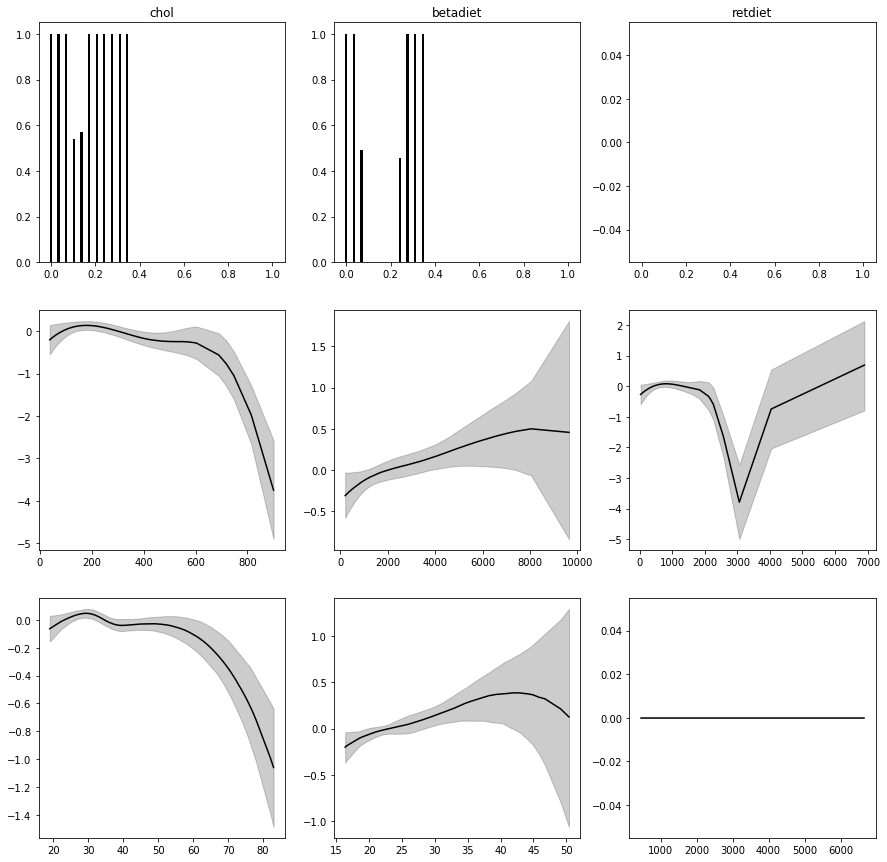

In [135]:
ms1,cs1,ws1 = vselect_wo_beta(d_x7,y)
ms2,cs2,ws2 = vselect_wo_beta(d_x8,y)
ms3,cs3,ws3 = vselect_wo_beta(d_x9,y)

plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title(colName[7])
plt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

plt.subplot(332)
plt.title(colName[8])
plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

plt.subplot(333)
plt.title(colName[9])
plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')



plt.subplot(334)
#plt.title('f1')
ci95srd(m7,c7,x7,d_x7)

plt.subplot(335)
#plt.title('f2')
ci95srd(m8,c8,x8,d_x8)

plt.subplot(336)
#plt.title('f3')
ci95srd(m9,c9,x9,d_x9)



plt.subplot(337)
#plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1)

plt.subplot(338)
#plt.title('f2')
cil95s(ms2,cs2,ws2,x2,d_x2)

plt.subplot(339)
#plt.title('f3')
cil95s(ms3,cs3,ws3,x3,d_x3)


plt.show()

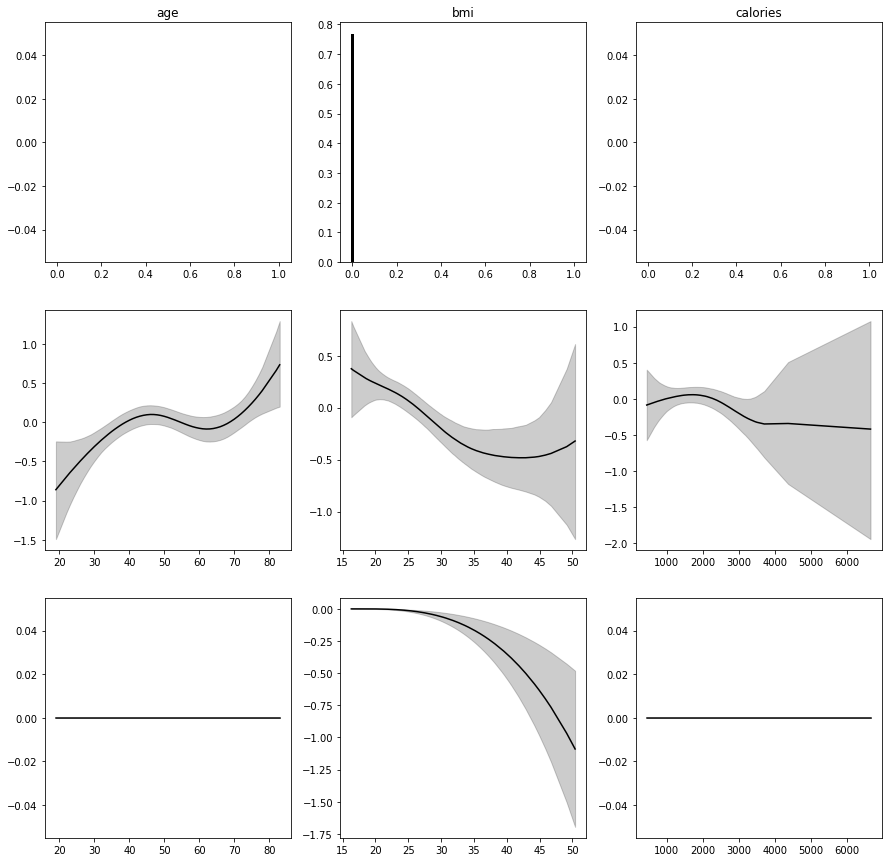

In [131]:
ms1,cs1,ws1 = vselect_with_beta(d_x1,y)
ms2,cs2,ws2 = vselect_with_beta(d_x2,y)
ms3,cs3,ws3 = vselect_with_beta(d_x3,y)
ms4,cs4,ws4 = vselect_with_beta(d_x4,y)
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title(colName[1])
plt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

plt.subplot(332)
plt.title(colName[2])
plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

plt.subplot(333)
plt.title(colName[3])
plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')



plt.subplot(334)
#plt.title('f1')
ci95srd(m1,c1,x1,d_x1)

plt.subplot(335)
#plt.title('f2')
ci95srd(m2,c2,x2,d_x2)

plt.subplot(336)
#plt.title('f3')
ci95srd(m3,c3,x3,d_x3)



plt.subplot(337)
#plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1)

plt.subplot(338)
#plt.title('f2')
cil95s(ms2,cs2,ws2,x2,d_x2)

plt.subplot(339)
#plt.title('f3')
cil95s(ms3,cs3,ws3,x3,d_x3)


plt.show()

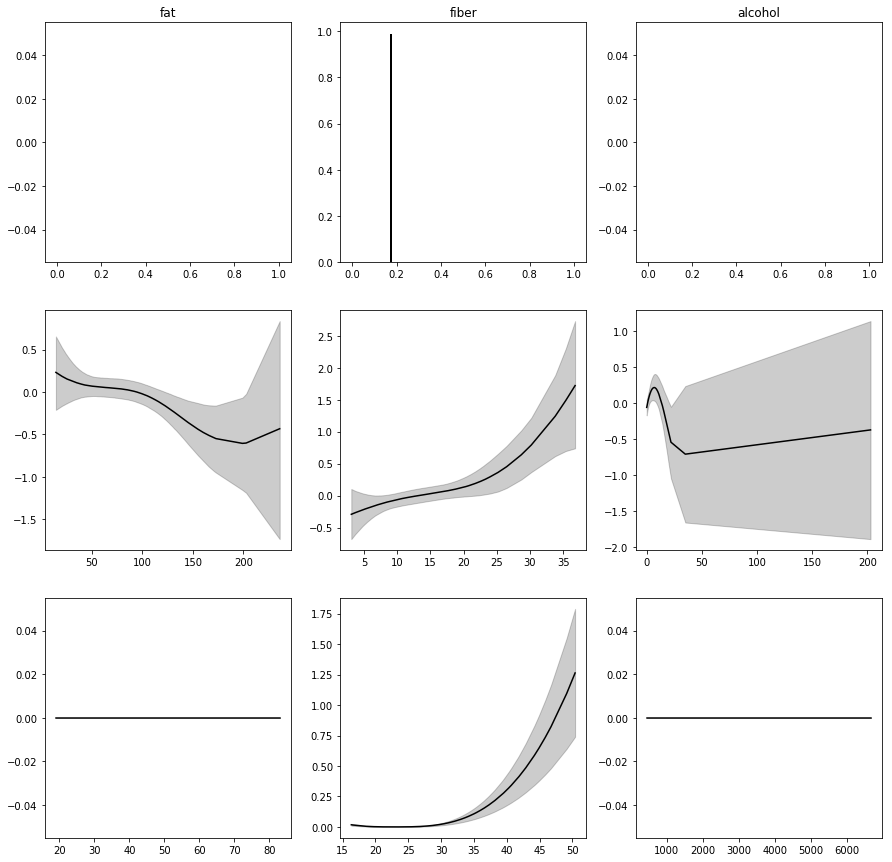

In [137]:
ms1,cs1,ws1 = vselect_with_beta(d_x4,y)
ms2,cs2,ws2 = vselect_with_beta(d_x5,y)
ms3,cs3,ws3 = vselect_with_beta(d_x6,y)

plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title(colName[4])
plt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

plt.subplot(332)
plt.title(colName[5])
plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

plt.subplot(333)
plt.title(colName[6])
plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')



plt.subplot(334)
#plt.title('f1')
ci95srd(m4,c4,x4,d_x4)

plt.subplot(335)
#plt.title('f2')
ci95srd(m5,c5,x5,d_x5)

plt.subplot(336)
#plt.title('f3')
ci95srd(m6,c6,x6,d_x6)



plt.subplot(337)
#plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1)

plt.subplot(338)
#plt.title('f2')
cil95s(ms2,cs2,ws2,x2,d_x2)

plt.subplot(339)
#plt.title('f3')
cil95s(ms3,cs3,ws3,x3,d_x3)


plt.show()

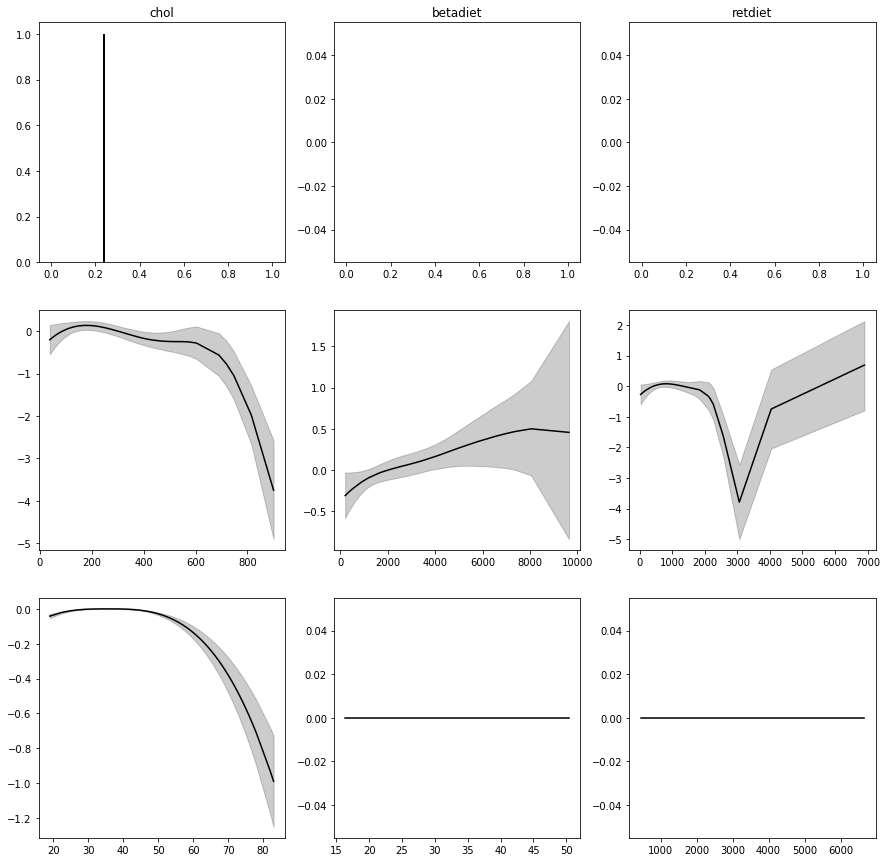

In [138]:
ms1,cs1,ws1 = vselect_with_beta(d_x7,y)
ms2,cs2,ws2 = vselect_with_beta(d_x8,y)
ms3,cs3,ws3 = vselect_with_beta(d_x9,y)

plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title(colName[7])
plt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

plt.subplot(332)
plt.title(colName[8])
plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

plt.subplot(333)
plt.title(colName[9])
plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')



plt.subplot(334)
#plt.title('f1')
ci95srd(m7,c7,x7,d_x7)

plt.subplot(335)
#plt.title('f2')
ci95srd(m8,c8,x8,d_x8)

plt.subplot(336)
#plt.title('f3')
ci95srd(m9,c9,x9,d_x9)



plt.subplot(337)
#plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1)

plt.subplot(338)
#plt.title('f2')
cil95s(ms2,cs2,ws2,x2,d_x2)

plt.subplot(339)
#plt.title('f3')
cil95s(ms3,cs3,ws3,x3,d_x3)


plt.show()

C:\Users\SUIC_STAR\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\SUIC_STAR\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\SUIC_STAR\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


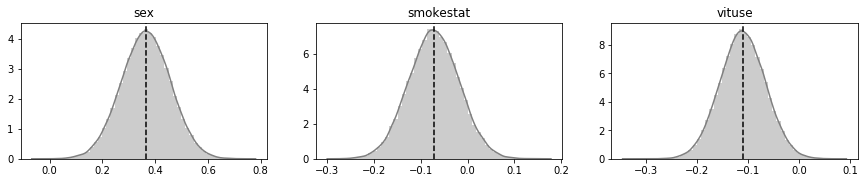

In [139]:
lms4,lcs4,lws4 = vselect_with_beta(Z,y)
plt.figure(figsize=(15,2.5))

plt.subplot(131)
plt.title(linearName[1])
if lws4[0]!=0:
    sns.distplot(np.random.normal(lms4[0],np.sqrt(lcs4[0,0]),100000),color = 'gray')
    plt.axvline(lms4[0], color = 'k',linestyle='--')
else:
    sns.distplot(np.repeat(0,100000),color = 'gray')
    plt.axvline(-0, color = 'k',linestyle='--')

plt.subplot(132)
plt.title(linearName[2])
if lws4[1]!=0:
    sns.distplot(np.random.normal(lms4[1],np.sqrt(lcs4[1,1]),100000),color = 'gray')
    plt.axvline(lms4[1], color = 'k',linestyle='--')
else:
    sns.distplot(np.repeat(0,100000),color = 'gray')
    plt.axvline(-0, color = 'k',linestyle='--')
    
plt.subplot(133)
plt.title(linearName[3])
if lws4[2]!=0:
    sns.distplot(np.random.normal(lms4[2],np.sqrt(lcs4[2,2]),100000),color = 'gray')
    plt.axvline(lms4[2], color = 'k',linestyle='--')
else:
    sns.distplot(np.repeat(0,100000),color = 'gray')
    plt.axvline(-0, color = 'k',linestyle='--')
plt.show()